# COGS 108 - EDA Checkpoint

# Names

- Fadi Elhayek
- Ivy Duggan
- Joshua Guiman (lead on EDA checkpoint)
- Yu-Hsuan Chi (lead on EDA checkpoint)

<a id='research_question'></a>
# Research Question

Are there any key indicators on a game's store page as to whether or not it is good? (ie. Can this be determined through sentiment analysis of the name/blurb/genres, the mismatch of developer & user tagged genres, recent/overall reviews, release date, metacritic score, and maturity rating, etc.?


# Setup

In [342]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (20, 8)

import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
import nltk
from nltk.tokenize import word_tokenize

## uncomment following 3 lines to download nltk stopwords, punkt, and lexicon
#nltk.download('stopwords')
#nltk.download('punkt')
#nltk.download('vader_lexicon') #lexicon used for sentiment analysis

#import stopwords
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

#import stemmer
from nltk.stem import PorterStemmer
ps = PorterStemmer()

#import word frequency tracker
from nltk.probability import FreqDist

#import sentiment analyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer 
analyzer = SentimentIntensityAnalyzer()


list_converter = lambda x: x.strip("[]").strip("()").lower().split(", ") # need to read lists inside the csv!
df = pd.read_csv(
    'df_clean.csv', 
    converters={
        'user_tags_list': list_converter,
        'developer_genres_list': list_converter,
        'game_features_list': list_converter
    })

In [343]:
df_clean = df.drop_duplicates(subset='app_id', keep="first")
df_clean = df_clean.drop(columns=['Unnamed: 0'])
df_clean.head(50)

,app_id,game_name,release_date,game_blurb,esrb_rating_numeric,total_review_score_numeric,recent_review_score_numeric,review_count,critic_score,critic_name,user_tags_list,developer_genres_list,game_features_list
0,730,counter-strike: global offensive,"Aug 21, 2012",counter-strike: global offensive (cs: go) expa...,NaN,3.0,3.0,6731720,83,metacritic,"[""'fps'"", ""'shooter'"", ""'multiplayer'"", ""'comp...","[""'action'"", ""'free to play'""]","[""'steam achievements'"", ""'full controller sup..."
1,1938090,call of duty®: modern warfare® ii,"Oct 27, 2022",call of duty®: modern warfare® ii drops player...,4.0,NaN,NaN,none,none,none,"[""'fps'"", ""'action'"", ""'shooter'"", ""'multiplay...","[""'action'""]","[""'single-player'"", ""'online pvp'"", ""'online c..."
2,236390,war thunder,"Aug 15, 2013",war thunder is the most comprehensive free-to-...,3.0,1.0,1.0,341555,81,metacritic,"[""'free to play'"", ""'vehicular combat'"", ""'com...","[""'action'"", ""'free to play'"", ""'massively mul...","[""'single-player'"", ""'mmo'"", ""'online pvp'"", ""..."
3,1172470,apex legends™,"Nov 4, 2020","apex legends is the award-winning, free-to-pla...",3.0,3.0,1.0,527702,88,metacritic,"[""'free to play'"", ""'multiplayer'"", ""'battle r...","[""'action'"", ""'adventure'"", ""'free to play'""]","[""'online pvp'"", ""'online co-op'"", ""'steam ach..."
4,1599340,lost ark,"Feb 11, 2022",embark on an odyssey for the lost ark in a vas...,4.0,1.0,1.0,174373,none,none,"[""'mmorpg'"", ""'free to play'"", ""'action rpg'"",...","[""'action'"", ""'adventure'"", ""'free to play'"", ...","[""'single-player'"", ""'mmo'"", ""'online pvp'"", ""..."
5,294100,rimworld,"Oct 17, 2018",a sci-fi colony sim driven by an intelligent a...,NaN,4.0,4.0,121410,87,metacritic,"[""'colony sim'"", ""'base building'"", ""'survival...","[""'indie'"", ""'simulation'"", ""'strategy'""]","[""'single-player'"", ""'steam workshop'"", ""'stea..."
6,1085660,destiny 2,"Oct 1, 2019",destiny 2 is an action mmo with a single evolv...,3.0,3.0,1.0,501974,83,metacritic,"[""'free to play'"", ""'open world'"", ""'fps'"", ""'...","[""'action'"", ""'adventure'"", ""'free to play'""]","[""'single-player'"", ""'online pvp'"", ""'online c..."
7,1063730,new world,"Sep 28, 2021","explore a thrilling, open-world mmo filled wit...",3.0,0.0,3.0,204606,70,metacritic,"[""'massively multiplayer'"", ""'open world'"", ""'...","[""'action'"", ""'adventure'"", ""'massively multip...","[""'mmo'"", ""'online pvp'"", ""'online co-op'"", ""'..."
8,1687950,persona 5 royal,"Oct 20, 2022",don the mask and join the phantom thieves of h...,4.0,NaN,NaN,none,95,metacritic,"[""'jrpg'"", ""'anime'"", ""'story rich'"", ""'rpg'"",...","[""'rpg'""]","[""'single-player'"", ""'steam achievements'"", ""'..."
9,548430,deep rock galactic,"May 13, 2020",deep rock galactic is a 1-4 player co-op fps f...,NaN,4.0,4.0,122870,85,metacritic,"[""'co-op'"", ""'pve'"", ""'fps'"", ""'exploration'"",...","[""'action'""]","[""'single-player'"", ""'online co-op'"", ""'steam ..."


# Data Cleaning

Describe your data cleaning steps here.
1. Remove games that are not released.
2. Remove non-English games (i.e. Games that have )
3. Remove symbols/tm

In [344]:
## Helper Variables and Functions used to clean data.
monthValues = {"Jan":1,"Feb":2,"Mar":3,"Apr":4,"May":5,"Jun":6,"Jul":7,"Aug":8,"Sep":9,"Oct":10,"Nov":11,"Dec":12,
              "January":1, "February":2, "March":3, "April":4, "June":6, "July":7, "August":8, "September":9,
              "October":10, "November":11,"December":12}
currentTime = ['Nov','19','2022']

def isReleased(releaseDate):
    mmddyear = releaseDate.split()
    if len(mmddyear) != 3: # Must have month, day and year to be processed cleanly.
        return False
    if mmddyear[0] not in monthValues.keys(): # if the month has strange format, return false.
        return False
    
    mmddyear[1] = mmddyear[1].replace(',','') # get rid of the comma attached to the day.
    if int(mmddyear[2]) < 2022: # check if year is before
        return True
    if int(mmddyear[2]) == 2022:
        if monthValues[mmddyear[0]] < monthValues[currentTime[0]]: #check if month is before
            return True
        if monthValues[mmddyear[0]] == monthValues[currentTime[0]]:
            if int(mmddyear[1]) <= int(currentTime[1]): #check if day is before
                return True
        
    return False
#-------------------------------------------------------------
def isEnglish(title):
    if title.lower() !=  title.upper(): #Filter out Japanese, Chinese, Korean, other non latin languages.
        return True
    return False
#-------------------------------------------------------------

def removeSymbols(text):
    removed = ''
    for c in text:
        if c.isalnum() or c == ' ' or c == '-':
            removed = removed + c
    removed = removed.replace('-', ' ') # - is a special case for titles and we need to replace it with space.
    return removed

print(removeSymbols(df_clean['game_name'][3]))

apex legends


In [345]:
# Tests for the above helper methods.
assert isReleased("Nov 19, 2022") == True
assert isReleased("Aug 30, 2022") == True
assert isReleased("Jan 1, 2000") == True
assert isReleased("Nov 20, 2022") == False
assert isReleased("Mar 1, 2023") == False

assert isEnglish("Call of Duty®: Modern Warfare® II") == True
assert isEnglish("안녕") == False


assert "Happy123" == removeSymbols("Happy!1,2?3")
assert "counter strike global offensive" == removeSymbols(df_clean['game_name'][0])

In [346]:
# Dedicated to removing rows.

# 1. remove rows that have "none" or "NaN"
df_clean = df_clean.dropna(subset=['game_name', 'game_blurb', 'release_date', 'total_review_score_numeric', 'recent_review_score_numeric'])

# 2. remove rows where the game name is not english or the was game was not released.
#This commented out solution works, but is slow.
#for index, row in df_clean.iterrows():
    #if isReleased(row['release_date']) == False:
        #df_clean.drop(index, inplace=True)

#for index, row in df_clean.iterrows():
    #if isEnglish(row['game_name']) == False:
        #df_clean.drop(index, inplace=True)

col_isEnglish = df_clean['game_name'].apply(isEnglish)  # Column for valid game names.
col_isReleased = df_clean['release_date'].apply(isReleased) #Column for games that are released.
for index, row in df_clean.iterrows():
    if col_isEnglish[index] == False or col_isReleased[index] == False:
        df_clean = df_clean.drop(index)

df_clean = df_clean.reset_index(drop=True)
df_clean.head(5)


,app_id,game_name,release_date,game_blurb,esrb_rating_numeric,total_review_score_numeric,recent_review_score_numeric,review_count,critic_score,critic_name,user_tags_list,developer_genres_list,game_features_list
0,730,counter-strike: global offensive,"Aug 21, 2012",counter-strike: global offensive (cs: go) expa...,NaN,3.0,3.0,6731720,83,metacritic,"[""'fps'"", ""'shooter'"", ""'multiplayer'"", ""'comp...","[""'action'"", ""'free to play'""]","[""'steam achievements'"", ""'full controller sup..."
1,236390,war thunder,"Aug 15, 2013",war thunder is the most comprehensive free-to-...,3.0,1.0,1.0,341555,81,metacritic,"[""'free to play'"", ""'vehicular combat'"", ""'com...","[""'action'"", ""'free to play'"", ""'massively mul...","[""'single-player'"", ""'mmo'"", ""'online pvp'"", ""..."
2,1172470,apex legends™,"Nov 4, 2020","apex legends is the award-winning, free-to-pla...",3.0,3.0,1.0,527702,88,metacritic,"[""'free to play'"", ""'multiplayer'"", ""'battle r...","[""'action'"", ""'adventure'"", ""'free to play'""]","[""'online pvp'"", ""'online co-op'"", ""'steam ach..."
3,1599340,lost ark,"Feb 11, 2022",embark on an odyssey for the lost ark in a vas...,4.0,1.0,1.0,174373,none,none,"[""'mmorpg'"", ""'free to play'"", ""'action rpg'"",...","[""'action'"", ""'adventure'"", ""'free to play'"", ...","[""'single-player'"", ""'mmo'"", ""'online pvp'"", ""..."
4,294100,rimworld,"Oct 17, 2018",a sci-fi colony sim driven by an intelligent a...,NaN,4.0,4.0,121410,87,metacritic,"[""'colony sim'"", ""'base building'"", ""'survival...","[""'indie'"", ""'simulation'"", ""'strategy'""]","[""'single-player'"", ""'steam workshop'"", ""'stea..."


In [347]:
#remove symbols, such as trademark and dash, from game_name and game_blurb for sentiment analysis
df_clean['game_name'] = df_clean['game_name'].apply(removeSymbols)
df_clean['game_blurb'] = df_clean['game_blurb'].apply(removeSymbols)

#turn total_review_score_numeric from string into integer
df_clean['total_review_score_numeric'] = df_clean['total_review_score_numeric'].astype(float)

df_clean.head()

,app_id,game_name,release_date,game_blurb,esrb_rating_numeric,total_review_score_numeric,recent_review_score_numeric,review_count,critic_score,critic_name,user_tags_list,developer_genres_list,game_features_list
0,730,counter strike global offensive,"Aug 21, 2012",counter strike global offensive cs go expands ...,NaN,3.0,3.0,6731720,83,metacritic,"[""'fps'"", ""'shooter'"", ""'multiplayer'"", ""'comp...","[""'action'"", ""'free to play'""]","[""'steam achievements'"", ""'full controller sup..."
1,236390,war thunder,"Aug 15, 2013",war thunder is the most comprehensive free to ...,3.0,1.0,1.0,341555,81,metacritic,"[""'free to play'"", ""'vehicular combat'"", ""'com...","[""'action'"", ""'free to play'"", ""'massively mul...","[""'single-player'"", ""'mmo'"", ""'online pvp'"", ""..."
2,1172470,apex legends,"Nov 4, 2020",apex legends is the award winning free to play...,3.0,3.0,1.0,527702,88,metacritic,"[""'free to play'"", ""'multiplayer'"", ""'battle r...","[""'action'"", ""'adventure'"", ""'free to play'""]","[""'online pvp'"", ""'online co-op'"", ""'steam ach..."
3,1599340,lost ark,"Feb 11, 2022",embark on an odyssey for the lost ark in a vas...,4.0,1.0,1.0,174373,none,none,"[""'mmorpg'"", ""'free to play'"", ""'action rpg'"",...","[""'action'"", ""'adventure'"", ""'free to play'"", ...","[""'single-player'"", ""'mmo'"", ""'online pvp'"", ""..."
4,294100,rimworld,"Oct 17, 2018",a sci fi colony sim driven by an intelligent a...,NaN,4.0,4.0,121410,87,metacritic,"[""'colony sim'"", ""'base building'"", ""'survival...","[""'indie'"", ""'simulation'"", ""'strategy'""]","[""'single-player'"", ""'steam workshop'"", ""'stea..."


# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section
1. Sentiment Analysis (Using nltk) on the 2 columns: game_name, game_blurb
2. Determine relationship between esrb rating and user ratings

In [348]:
## Variables that may predict game ratings
names = df_clean['game_name']
blurbs = df_clean['game_blurb']
dev_genres = df_clean['developer_genres_list']
user_tags = df_clean['user_tags_list']
game_feats = df_clean['game_features_list']
mature_ratings = df_clean[['game_name', 'esrb_rating_numeric', 'total_review_score_numeric']].dropna(subset=['esrb_rating_numeric']).reset_index(drop=True)

## Main measure for game ratings
# user ratings
user_ratings = df_clean['total_review_score_numeric']

In [349]:
# remove rows without metacritic score, then turn critic_score from string to integer
df_meta_only = df_clean[(df_clean['critic_score'] != 'none') | (df_clean['critic_name'] != 'none')]
df_meta_only['critic_score'] = df_meta_only['critic_score'].astype(int)

# metacritic ratings
critic_ratings = df_meta_only['critic_score']

C:\Users\hulk5\AppData\Local\Temp\ipykernel_10208\2451152772.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_meta_only['critic_score'] = df_meta_only['critic_score'].astype(int)


In [350]:
# prints the number of datapoints with valid user ratings
print(f'Games with user ratings: {user_ratings.size}')

# prints the number of datapoints with valid metacritic ratings
print(f'Games with metacritic ratings: {critic_ratings.size}')

Games with user ratings: 4898
Games with metacritic ratings: 1499


We can see that there are far fewer datapoints with user ratings than those with metacritic ratings. Therefore, we would like to see if there is a relationship between the two measures of game ratings, and whether or not it is possible to predict a game's metacritic rating if it had only received user ratings.

<AxesSubplot: xlabel='critic_score', ylabel='Count'>

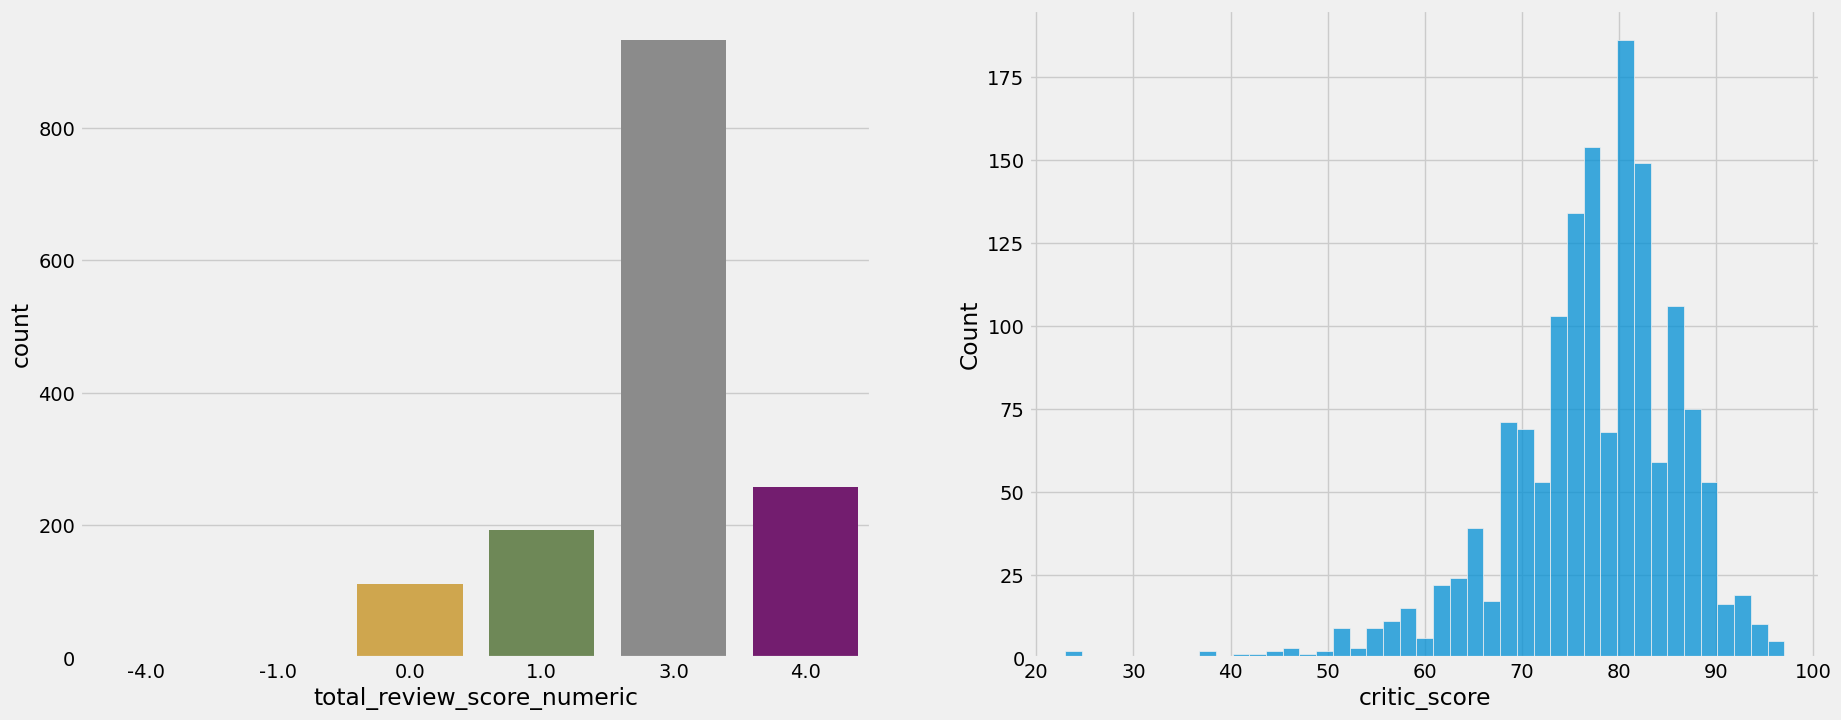

In [351]:
f1, (ax1, ax2) = plt.subplots(figsize =(20, 8), ncols=2)

sns.countplot(x='total_review_score_numeric', data=df_meta_only, ax=ax1)
sns.histplot(x=critic_ratings, ax=ax2)

By plotting out the distribution of the user ratings (total_review_score_numeric) and the metacritic ratings (critic_score), we can see that they have a similar distribution.

It is more commons for games to have only user ratings (total_review_score_numeric) than to have both user ratings and metacritic ratings (critic_score). Therefore, we might be able to predict the metacritic rating of a game based on its user ratings.

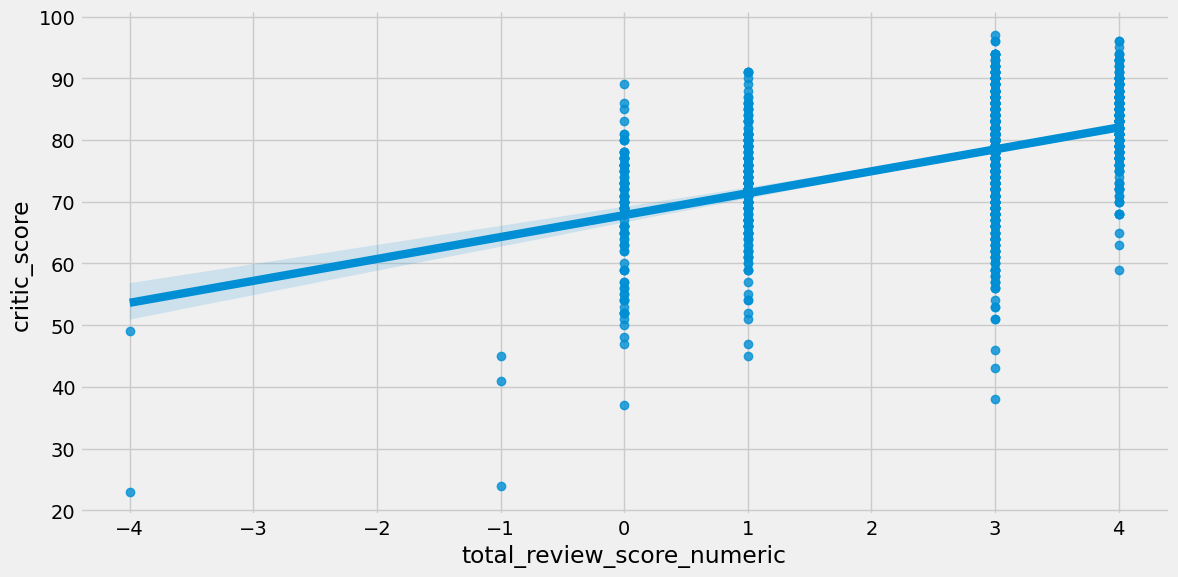

In [352]:
plt.style.use('fivethirtyeight')
sns.lmplot(x='total_review_score_numeric', y='critic_score', data=df_meta_only, height=6, aspect=2)

The graph above is a visualization of the relationship between user ratings (total_review_score_numeric) and metacritic ratings (critic_score).

In [353]:
model = sm.formula.ols(formula='critic_score ~ total_review_score_numeric', data=df_meta_only)
result = model.fit()

print(result.summary())

                            OLS Regression Results                            
Dep. Variable:           critic_score   R-squared:                       0.219
Model:                            OLS   Adj. R-squared:                  0.219
Method:                 Least Squares   F-statistic:                     420.1
Date:                Mon, 21 Nov 2022   Prob (F-statistic):           1.72e-82
Time:                        01:00:42   Log-Likelihood:                -5201.0
No. Observations:                1499   AIC:                         1.041e+04
Df Residuals:                    1497   BIC:                         1.042e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

According to the regression of metacritic ratings as a function of user ratings, user ratings may be used to predict the metacritic score of a game because it has a positive coefficient of 3.55 and a p-value of approximately 0. However, it does have a relatively low R-squared value of 0.219, so the prediction may not be as accurate.

**Since only a relatively small proportion of games on steam has a metacritic score, we will be using user ratings (total_review_score_numeric) as the main measure for game ratings.**

### **Predicting user ratings with game names and game blurbs**

First, we want to determine whether or not game names and game blurbs could predict game ratings. We will do so by performing sentiment analysis on both the game name and the game blurb of each game.\
We can start by finding out the most commonly used words in game names and game blurbs. 

In [354]:
# create dataframe containing only game names and game blurbs
df_name_blurb = pd.concat([names, blurbs], axis=1)

df_name_blurb.head()

,game_name,game_blurb
0,counter strike global offensive,counter strike global offensive cs go expands ...
1,war thunder,war thunder is the most comprehensive free to ...
2,apex legends,apex legends is the award winning free to play...
3,lost ark,embark on an odyssey for the lost ark in a vas...
4,rimworld,a sci fi colony sim driven by an intelligent a...


In [355]:
# tokenize game_name and game_blurb, then put the respective results under name_token and blurb_token
df_name_blurb['name_token'] = df_name_blurb['game_name'].apply(word_tokenize)
df_name_blurb['blurb_token'] = df_name_blurb['game_blurb'].apply(word_tokenize)

df_name_blurb.head()

,game_name,game_blurb,name_token,blurb_token
0,counter strike global offensive,counter strike global offensive cs go expands ...,"[counter, strike, global, offensive]","[counter, strike, global, offensive, cs, go, e..."
1,war thunder,war thunder is the most comprehensive free to ...,"[war, thunder]","[war, thunder, is, the, most, comprehensive, f..."
2,apex legends,apex legends is the award winning free to play...,"[apex, legends]","[apex, legends, is, the, award, winning, free,..."
3,lost ark,embark on an odyssey for the lost ark in a vas...,"[lost, ark]","[embark, on, an, odyssey, for, the, lost, ark,..."
4,rimworld,a sci fi colony sim driven by an intelligent a...,[rimworld],"[a, sci, fi, colony, sim, driven, by, an, inte..."


In [356]:
# remove stopwords from name_token and blurb_token, then put the respective results under name_stop and blurb_stop
df_name_blurb['name_stop'] = df_name_blurb['name_token'].apply(lambda x: [word for word in x if word not in stop_words])
df_name_blurb['blurb_stop'] = df_name_blurb['blurb_token'].apply(lambda x: [word for word in x if word not in stop_words])

df_name_blurb.head()

,game_name,game_blurb,name_token,blurb_token,name_stop,blurb_stop
0,counter strike global offensive,counter strike global offensive cs go expands ...,"[counter, strike, global, offensive]","[counter, strike, global, offensive, cs, go, e...","[counter, strike, global, offensive]","[counter, strike, global, offensive, cs, go, e..."
1,war thunder,war thunder is the most comprehensive free to ...,"[war, thunder]","[war, thunder, is, the, most, comprehensive, f...","[war, thunder]","[war, thunder, comprehensive, free, play, cros..."
2,apex legends,apex legends is the award winning free to play...,"[apex, legends]","[apex, legends, is, the, award, winning, free,...","[apex, legends]","[apex, legends, award, winning, free, play, he..."
3,lost ark,embark on an odyssey for the lost ark in a vas...,"[lost, ark]","[embark, on, an, odyssey, for, the, lost, ark,...","[lost, ark]","[embark, odyssey, lost, ark, vast, vibrant, wo..."
4,rimworld,a sci fi colony sim driven by an intelligent a...,[rimworld],"[a, sci, fi, colony, sim, driven, by, an, inte...",[rimworld],"[sci, fi, colony, sim, driven, intelligent, ai..."


In [357]:
# stem all words in name_stop and blurb_stop, then put the respective results under name_clean and blurb_clean
df_name_blurb['name_clean'] = df_name_blurb['name_stop'].apply(lambda x: [ps.stem(word) for word in x])
df_name_blurb['blurb_clean'] = df_name_blurb['blurb_stop'].apply(lambda x: [ps.stem(word) for word in x])

df_name_blurb.head()

,game_name,game_blurb,name_token,blurb_token,name_stop,blurb_stop,name_clean,blurb_clean
0,counter strike global offensive,counter strike global offensive cs go expands ...,"[counter, strike, global, offensive]","[counter, strike, global, offensive, cs, go, e...","[counter, strike, global, offensive]","[counter, strike, global, offensive, cs, go, e...","[counter, strike, global, offens]","[counter, strike, global, offens, cs, go, expa..."
1,war thunder,war thunder is the most comprehensive free to ...,"[war, thunder]","[war, thunder, is, the, most, comprehensive, f...","[war, thunder]","[war, thunder, comprehensive, free, play, cros...","[war, thunder]","[war, thunder, comprehens, free, play, cross, ..."
2,apex legends,apex legends is the award winning free to play...,"[apex, legends]","[apex, legends, is, the, award, winning, free,...","[apex, legends]","[apex, legends, award, winning, free, play, he...","[apex, legend]","[apex, legend, award, win, free, play, hero, s..."
3,lost ark,embark on an odyssey for the lost ark in a vas...,"[lost, ark]","[embark, on, an, odyssey, for, the, lost, ark,...","[lost, ark]","[embark, odyssey, lost, ark, vast, vibrant, wo...","[lost, ark]","[embark, odyssey, lost, ark, vast, vibrant, wo..."
4,rimworld,a sci fi colony sim driven by an intelligent a...,[rimworld],"[a, sci, fi, colony, sim, driven, by, an, inte...",[rimworld],"[sci, fi, colony, sim, driven, intelligent, ai...",[rimworld],"[sci, fi, coloni, sim, driven, intellig, ai, s..."


In [358]:
# remove numbers from words used in game names and game blurbs
df_name_blurb['name_clean'] = df_name_blurb['name_clean'].apply(lambda x: [word for word in x if not word.isnumeric()])
df_name_blurb['blurb_clean'] = df_name_blurb['blurb_clean'].apply(lambda x: [word for word in x if not word.isnumeric()])

# turn the list of words in each game name and game blurb into series
name_words = df_name_blurb['name_clean'].apply(pd.Series).stack()
blurb_words = df_name_blurb['blurb_clean'].apply(pd.Series).stack()

# calculate the most frequently used words in game names and game blurbs
name_words_freq = FreqDist(name_words)
blurb_words_freq = FreqDist(blurb_words)

C:\Users\hulk5\AppData\Local\Temp\ipykernel_10208\1371590101.py:6: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  name_words = df_name_blurb['name_clean'].apply(pd.Series).stack()
C:\Users\hulk5\AppData\Local\Temp\ipykernel_10208\1371590101.py:7: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  blurb_words = df_name_blurb['blurb_clean'].apply(pd.Series).stack()


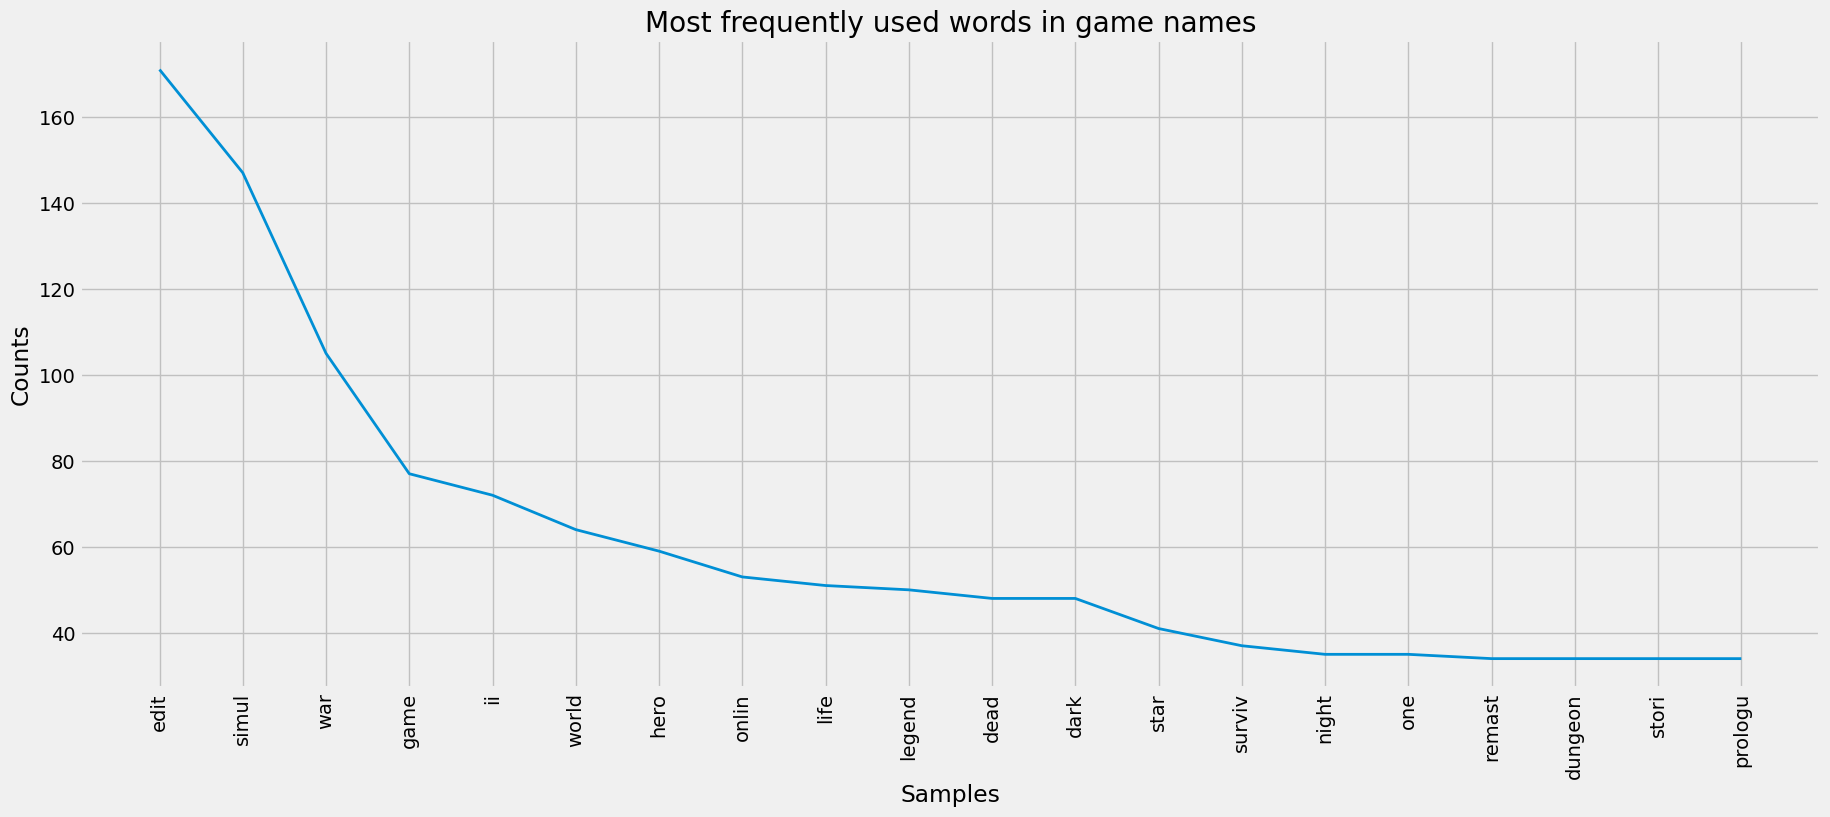

<AxesSubplot: title={'center': 'Most frequently used words in game names'}, xlabel='Samples', ylabel='Counts'>

In [359]:
# plot the top 20 most used words in game names
name_words_freq.plot(20, title='Most frequently used words in game names')

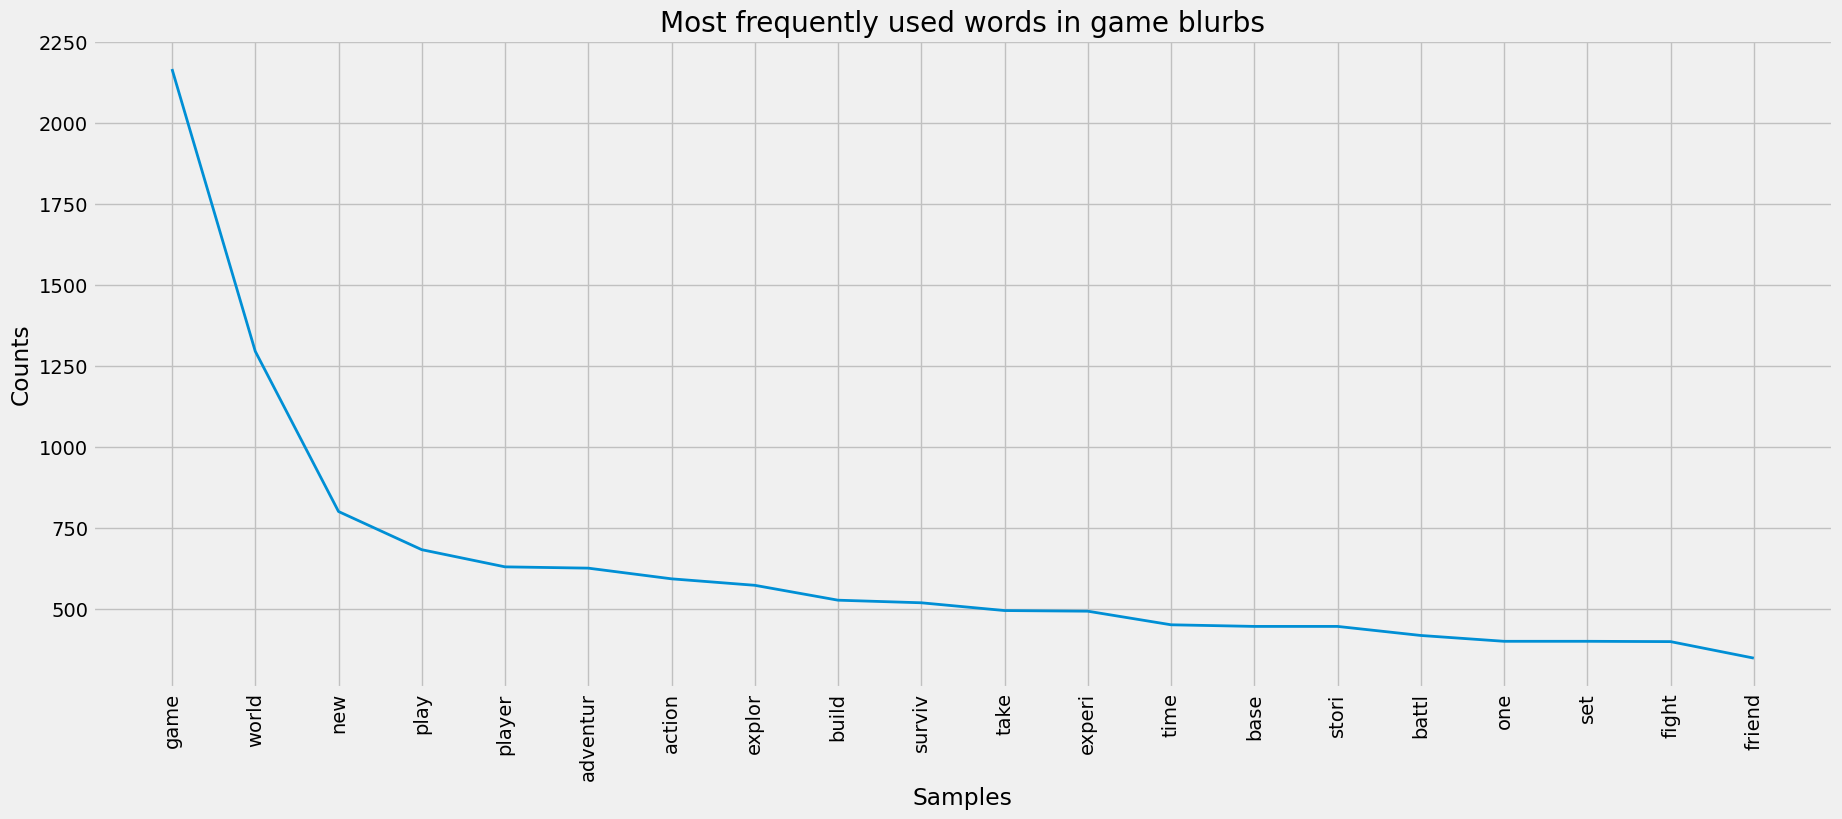

<AxesSubplot: title={'center': 'Most frequently used words in game blurbs'}, xlabel='Samples', ylabel='Counts'>

In [360]:
# plot the top 20 most used words in game blurbs
blurb_words_freq.plot(20, title='Most frequently used words in game blurbs')

We see that the most frequently used words in game names, aside from edit which stands for edition, are simul and war. Simul likely stands for simulation or simulator.\
The most frequently used words in game blurbs are games, world, and new.

Next, we can start to perform sentiment analysis on game names and game blurbs, then see how the results from the analyses correlate with user ratings.

In [361]:
# function for creating sentiment analysis results
def getSentiment(ratings, col, col_name):
    out = pd.DataFrame()

    for sentence in col:
        ss = pd.DataFrame([analyzer.polarity_scores(sentence)])
        ss[col_name] = sentence
        out = pd.concat([out, ss], axis=0)
    
    out = out.reset_index(drop=True)
    out['user_ratings'] = ratings

    return out

In [362]:
# game_name sentiment analysis results
name_sentiment = getSentiment(user_ratings, df_name_blurb['game_name'], 'game_name')
name_sentiment.head(10)

,neg,neu,pos,compound,game_name,user_ratings
0,0.692,0.308,0.0,-0.5423,counter strike global offensive,3.0
1,0.796,0.204,0.0,-0.5994,war thunder,1.0
2,0.000,1.000,0.0,0.0000,apex legends,3.0
3,0.697,0.303,0.0,-0.3182,lost ark,1.0
4,0.000,1.000,0.0,0.0000,rimworld,4.0
5,0.000,1.000,0.0,0.0000,destiny 2,3.0
6,0.000,1.000,0.0,0.0000,new world,0.0
7,0.000,1.000,0.0,0.0000,deep rock galactic,4.0
8,0.000,1.000,0.0,0.0000,dota 2,3.0
9,0.557,0.143,0.3,-0.4215,god of war,4.0


In [363]:
# game_blurb sentiment analysis results
blurb_sentiment = getSentiment(user_ratings, df_name_blurb['game_blurb'], 'game_blurb')
blurb_sentiment

,neg,neu,pos,compound,game_blurb,user_ratings
0,0.150,0.791,0.059,-0.6705,counter strike global offensive cs go expands ...,3.0
1,0.139,0.622,0.239,0.6809,war thunder is the most comprehensive free to ...,1.0
2,0.039,0.448,0.513,0.9831,apex legends is the award winning free to play...,3.0
3,0.146,0.542,0.312,0.8402,embark on an odyssey for the lost ark in a vas...,1.0
4,0.074,0.833,0.093,0.1531,a sci fi colony sim driven by an intelligent a...,4.0
...,...,...,...,...,...,...
4893,0.000,1.000,0.000,0.0000,retirement simulator is a game that simulates ...,-1.0
4894,0.232,0.768,0.000,-0.8979,wreak havoc in clone carnage this standalone d...,-1.0
4895,0.000,1.000,0.000,0.0000,in spacebase df 9 youll build a home among the...,-4.0
4896,0.000,0.455,0.545,0.9719,download friends pass and play it takes two wi...,3.0


We can first take a look at the distribution of the compound values of the sentiment analyses. 

(-1.0, 1.0)

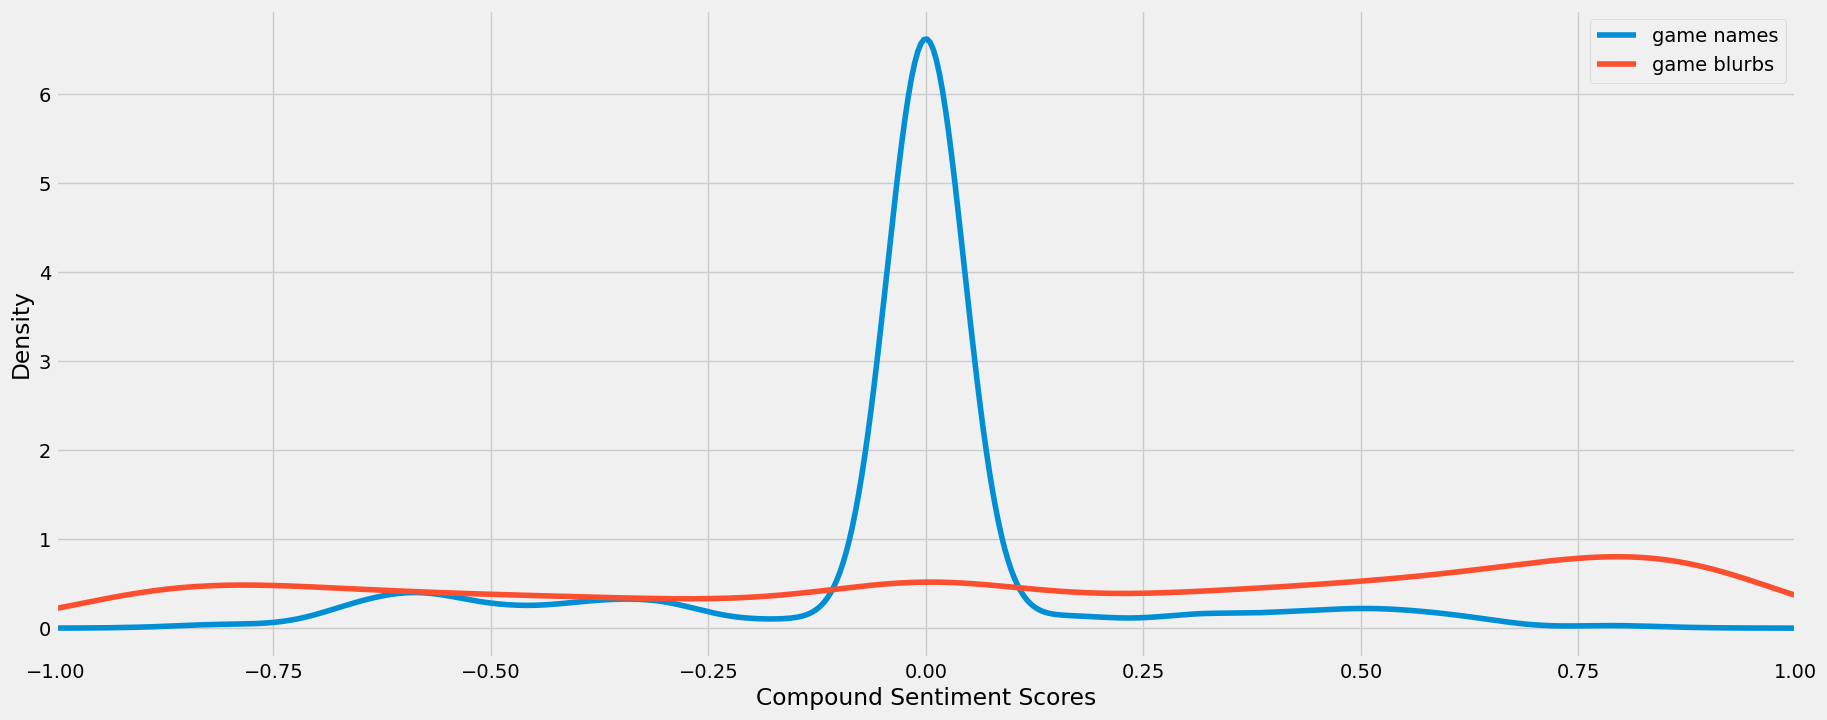

In [364]:

name_sentiment['compound'].plot.density(label='game names')
blurb_sentiment['compound'].plot.density(label='game blurbs')
plt.legend()
plt.xlabel('Compound Sentiment Scores')
plt.xlim(-1,1)

The graph shows that the sentiment values for game names are mostly neutral, while the sentiment values for game blurbs range from -1 to 1 with almost a uniform distribution.\
Next, we can plot the relationships between the compound values of the two anaylses and user ratings.

[Text(0.5, 1.0, 'game blurb sentiment analysis')]

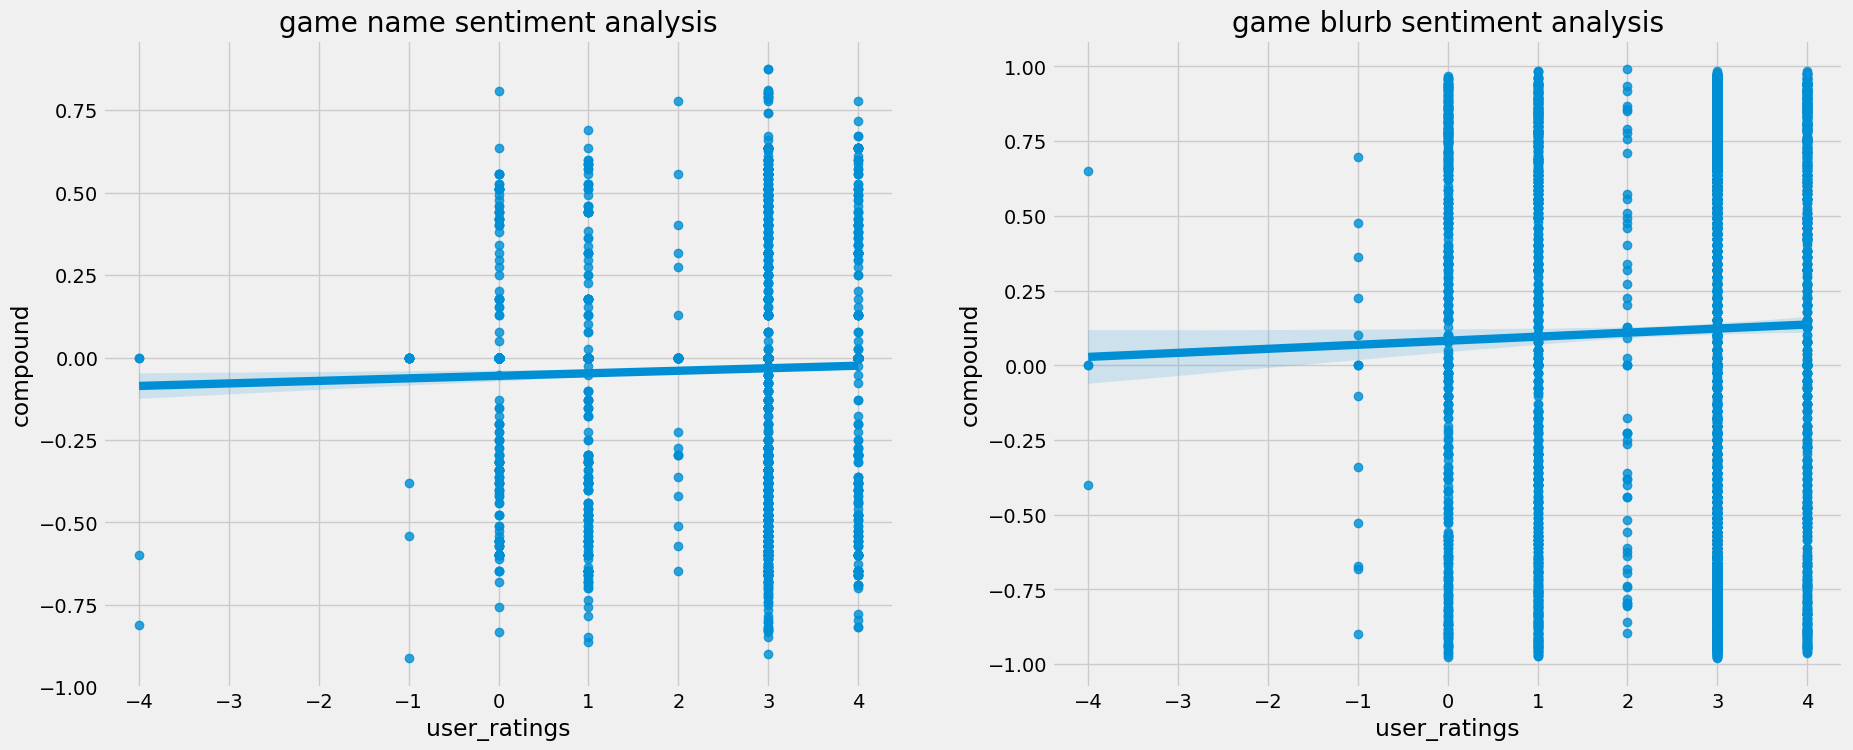

In [365]:
fig, (ax1, ax2) = plt.subplots(figsize =(20, 8), ncols=2)

sns.regplot(x='user_ratings', y='compound', data=name_sentiment, ax=ax1).set(title='game name sentiment analysis')
sns.regplot(x='user_ratings', y='compound', data=blurb_sentiment, ax=ax2).set(title='game blurb sentiment analysis')

The graphs show that there is no strong relationship between game name and user ratings, nor between game blurb and user ratings.\
Let's double check the relationship with linear regression.

In [366]:
mod1 = sm.formula.ols(formula='user_ratings ~ compound', data=name_sentiment)
res1 = mod1.fit()

print(res1.summary())

                            OLS Regression Results                            
Dep. Variable:           user_ratings   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     7.265
Date:                Mon, 21 Nov 2022   Prob (F-statistic):            0.00705
Time:                        01:00:58   Log-Likelihood:                -7905.6
No. Observations:                4898   AIC:                         1.582e+04
Df Residuals:                    4896   BIC:                         1.583e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5521      0.018    145.326      0.0

The regression above shows that there is an extremely weak positive relationship between game name and user ratings. It has a coefficient of 0.1932 and a p-value of 0.007.

In [367]:
mod2 = sm.formula.ols(formula='user_ratings ~ compound', data=blurb_sentiment)
res2 = mod2.fit()

print(res2.summary())

                            OLS Regression Results                            
Dep. Variable:           user_ratings   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     3.590
Date:                Mon, 21 Nov 2022   Prob (F-statistic):             0.0582
Time:                        01:00:58   Log-Likelihood:                -7907.4
No. Observations:                4898   AIC:                         1.582e+04
Df Residuals:                    4896   BIC:                         1.583e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.5388      0.018    143.483      0.0

The regression above shows that there is no relationship between game blurb and user ratings. The p-value is above 0.05 and the margins of the coefficient includes zero.

We performed sentiment analysis on game names and game blurbs using the vader lexicon, and the results show that there is no relationship between game name and user ratings or between game blurb and user ratings. Although the coefficient of the regression of user ratings as a function of game names is postive and has a p-value of 0.007, the R-squared (0.001) is barely above zero. As a result, the predictive power of game names is extremely limited. Therefore, we cannot predict game ratings using only game names or game blurbs.

### **Predicting user ratings with esrb ratings**

In [368]:
# turn esrb_rating_numeric values from string to float
mature_ratings['esrb_rating_numeric'].astype(float)

mature_ratings

,game_name,esrb_rating_numeric,total_review_score_numeric
0,war thunder,3.0,1.0
1,apex legends,3.0,3.0
2,lost ark,4.0,1.0
3,destiny 2,3.0,3.0
4,new world,3.0,0.0
...,...,...,...
1553,kane and lynch dead men,4.0,0.0
1554,deus ex the fall,4.0,-1.0
1555,destroy all humans clone carnage,3.0,-1.0
1556,it takes two friends pass,3.0,3.0


First, we can try to visualize the relationship between esrb ratings and user ratings with a scatterplot and the line of best fit.

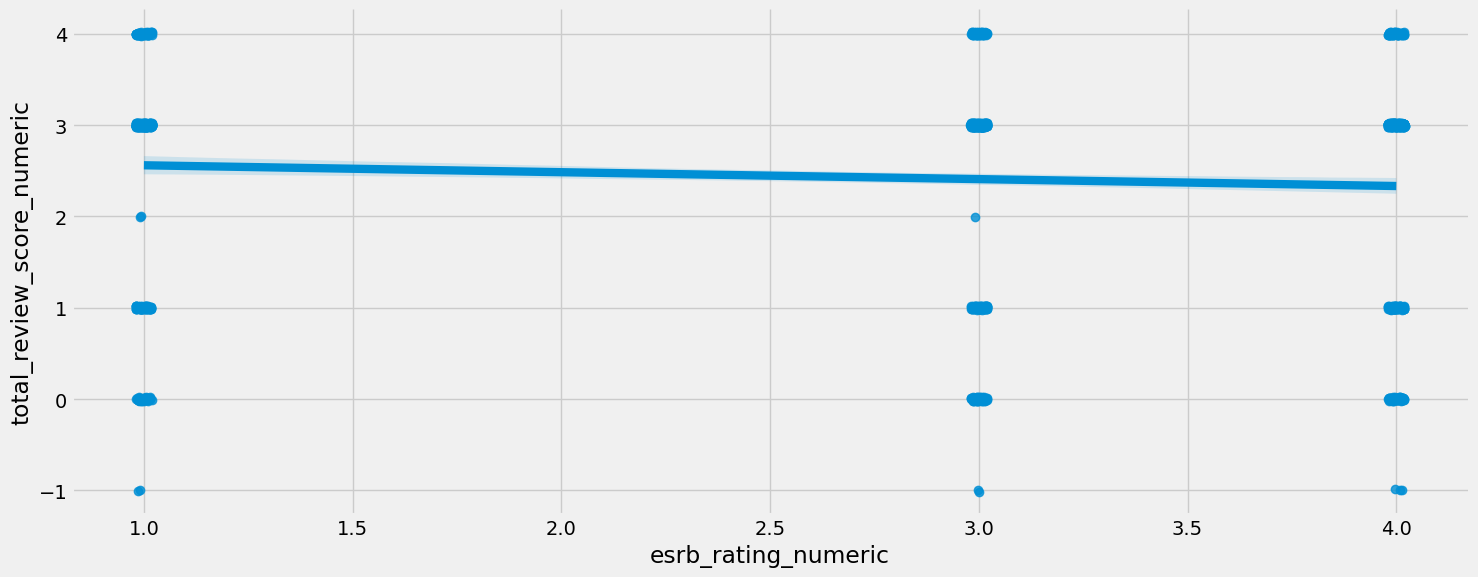

In [369]:
sns.lmplot(x='esrb_rating_numeric', y='total_review_score_numeric', data=mature_ratings, height=6, aspect=2.5, x_jitter=.02, y_jitter=.02)

We can see that there is a weak negative relationship between esrb ratings and user ratings.\
Let's double check with a linear regression.

In [370]:
model = sm.formula.ols(formula='total_review_score_numeric ~ esrb_rating_numeric', data=mature_ratings)
result = model.fit()

print(result.summary())

                                OLS Regression Results                                
Dep. Variable:     total_review_score_numeric   R-squared:                       0.005
Model:                                    OLS   Adj. R-squared:                  0.005
Method:                         Least Squares   F-statistic:                     8.583
Date:                        Mon, 21 Nov 2022   Prob (F-statistic):            0.00344
Time:                                01:00:58   Log-Likelihood:                -2531.3
No. Observations:                        1558   AIC:                             5067.
Df Residuals:                            1556   BIC:                             5077.
Df Model:                                   1                                         
Covariance Type:                    nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------

According to the regression, there is indeed a weak negative relationship between esrb ratings and user ratings. We know this because it has a coefficient of -0.0757 with a p-value of 0.003. However, similar to the regression between game names and user ratings, this has a R-squared value of only 0.005, meaning the prediction made solely with esrb ratings will not be as accurate. 

Nonetheless, we noticed that simply having an esrb rating might be an indicator of having better user ratings.\
Thus, we want to see if there's a difference in user ratings between games that received esrb ratings and those that did not receive esrb ratings.

In [371]:
# new dataframe
df_received_esrb = df_clean[['esrb_rating_numeric', 'total_review_score_numeric']]

# add column showing whether or not a game received esrb ratings
df_received_esrb['received_esrb'] = df_received_esrb['esrb_rating_numeric'].notnull()
df_received_esrb

C:\Users\hulk5\AppData\Local\Temp\ipykernel_10208\3717107093.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_received_esrb['received_esrb'] = df_received_esrb['esrb_rating_numeric'].notnull()


,esrb_rating_numeric,total_review_score_numeric,received_esrb
0,NaN,3.0,False
1,3.0,1.0,True
2,3.0,3.0,True
3,4.0,1.0,True
4,NaN,4.0,False
...,...,...,...
4893,NaN,-1.0,False
4894,3.0,-1.0,True
4895,NaN,-4.0,False
4896,3.0,3.0,True


<AxesSubplot: xlabel='received_esrb', ylabel='total_review_score_numeric'>

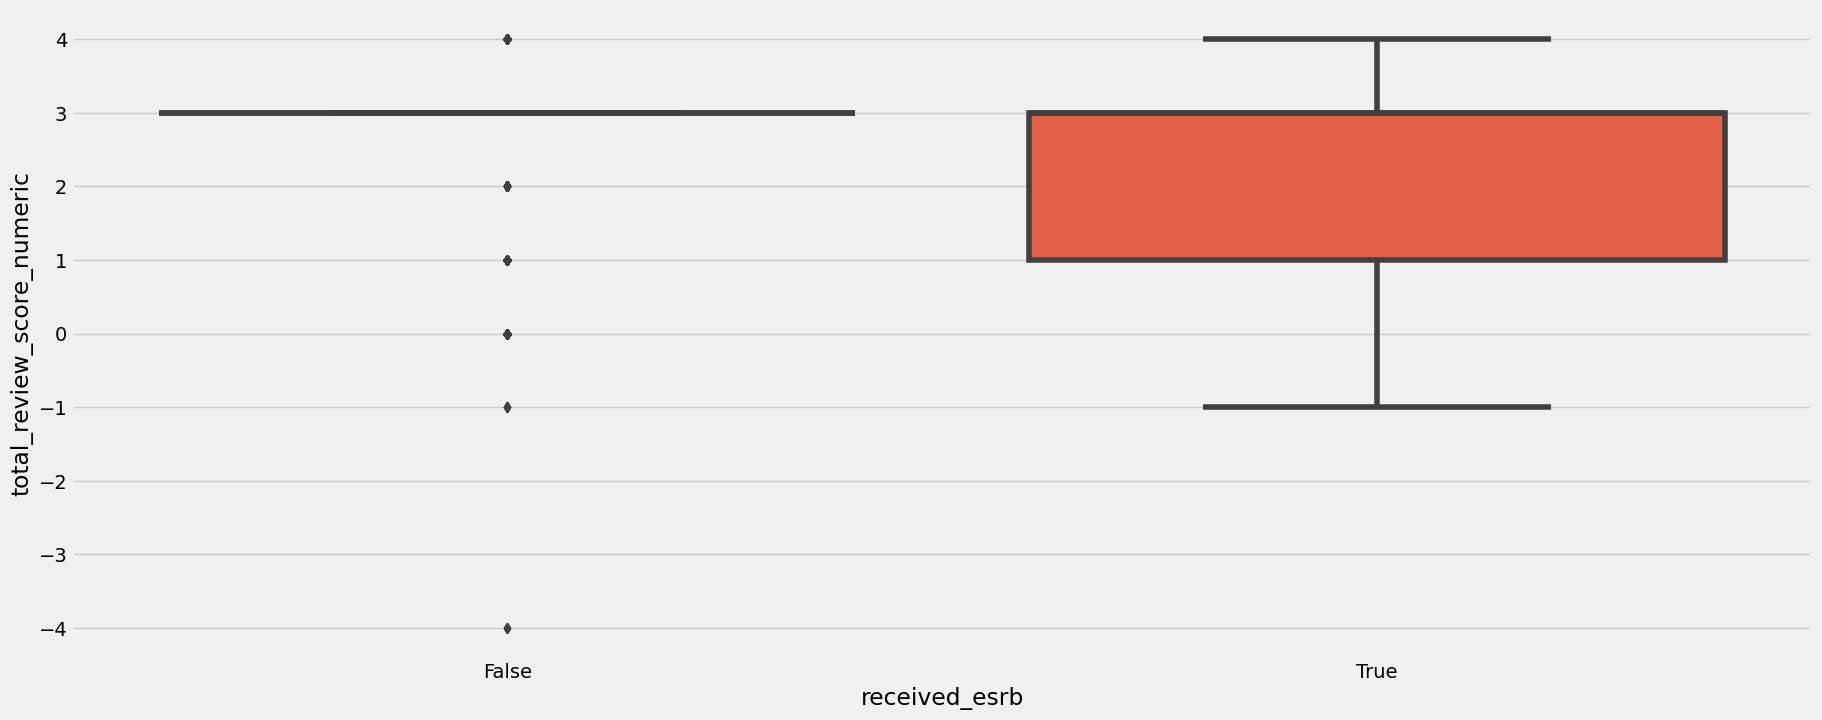

In [372]:
fig, ax = plt.subplots(figsize=(20, 8))

sns.boxplot(x='received_esrb', y='total_review_score_numeric', data=df_received_esrb)

There does not seem to be a significant difference in user ratings between games with esrb ratings and those without esrb ratings.\
let's double check the mean values and IQR of these games.

In [373]:
got_esrb = df_received_esrb.loc[(df_received_esrb['received_esrb'] == True), ['total_review_score_numeric']] # user ratings of games with esrb ratings
no_esrb = df_received_esrb.loc[(df_received_esrb['received_esrb'] == False), ['total_review_score_numeric']] # user ratings of games without esrb ratings

In [374]:
# descriptive stats of games with esrb
got_esrb.describe()

,total_review_score_numeric
count,1558.000000
mean,2.422978
std,1.232262
min,-1.000000
25%,1.000000
50%,3.000000
75%,3.000000
max,4.000000


In [375]:
# descriptive stats of games without esrb
no_esrb.describe()

,total_review_score_numeric
count,3340.000000
mean,2.602096
std,1.204984
min,-4.000000
25%,3.000000
50%,3.000000
75%,3.000000
max,4.000000


Turns out games without esrb ratings seem to have slightly higher user ratings in general than games with esrb ratings.